# Radius of curvature: code generation with a computer algebra system

Demonstrate the automatic generation of code to compute the radius of curvature and its gradients for use in a collective variable with [PLUMED2](http://www.plumed.org/). It is a companion file to the following paper:

> T. Giorgino. Practical Approaches to Differentiate Collective Variables in Free Energy Codes: Computer-Algebra Code Generation and Automatic Differentiation. Comp. Phys. Comm. (submitted).

This code uses the [SymPy](http://www.sympy.org/) computer algebra system (tested on version 1.0). See the website for installation instructions. A convenient way to install is via [Conda](https://conda.io/).  

The  notebook can be executed interactively pressing shift-enter on each cell, or in batch using the `jupyter nbconvert --execute` command line. If you are reading the PDF version of this file, its runnable version is found in PLUMED 2's tree at `src/curvature/sympy_codegen/CurvatureCodegen.ipynb`.



## Standard SymPy initialization

In [3]:
from sympy import *
init_printing()

## Variable declaration
Declare vectors `r_1`, `r_2` and `r_3`. Each has components `x`, `y` and `z`. They correspond to the paper's $\mathbf{r}_i$. 

In [2]:
var("r_1x r_1y r_1z \
     r_2x r_2y r_2z \
     r_3x r_3y r_3z")
r_1=Matrix([r_1x, r_1y, r_1z])
r_2=Matrix([r_2x, r_2y, r_2z])  
r_3=Matrix([r_3x, r_3y, r_3z])

Also define vectors $r_{ij}$ as shorthands for the triangle sides. They correspond to $\mathbf r_{12}$, $\mathbf r_{23}$ and $\mathbf r_{13}$ in the paper (order and direction is irrelevant for this calculation).

In [3]:
r_12=r_1-r_2
r_23=r_2-r_3
r_13=r_1-r_3

The actual calculation uses the sine theorem for triangles:

$$
 2 R  = \frac { |\mathbf r_{13}| }{\sin \theta_{123}} \qquad \mbox{with} \qquad
 \cos \theta_{123} = \frac{ \mathbf r_{12} \cdot \mathbf r_{23} }{  |\mathbf r_{12} | |\mathbf r_{23} | }
$$


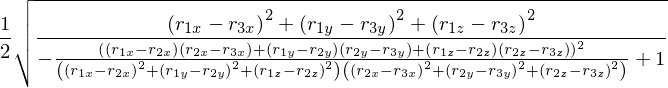

In [4]:
side2 = r_13.dot(r_13)
cos2a = r_12.dot(r_23)**2 / (r_12.dot(r_12) * r_23.dot(r_23))
sin2a = 1-cos2a

R2 = side2/sin2a/4

R=sqrt(R2)
R

## Compute gradients and generate code

Gradients are computed via the `derive_by_array` function. 

In [53]:
from sympy.tensor.array import derive_by_array
mgrad_1=derive_by_array(R,r_1).tomatrix()
mgrad_2=derive_by_array(R,r_2).tomatrix()
mgrad_3=derive_by_array(R,r_3).tomatrix()

# Use e.g. mgrad_1 to print the expressions. They are several lines long.

Code generation is performed with the  `codegen()` function, which will write `R` and the components of `mgrad_*` in the files `curvature_codegen.*`. 

In [6]:
from sympy.utilities.codegen import codegen
codegen([ ("curvature_radius",R),
          ("curvature_radius_grad",  [ 
                Eq(MatrixSymbol("g1",3,1),mgrad_1),
                Eq(MatrixSymbol("g2",3,1),mgrad_2),
                Eq(MatrixSymbol("g3",3,1),mgrad_3) ])],
             to_files=True,
             prefix="curvature_codegen",
             project="plumed_curvature",
             language="C")

This concludes the code generation necessary for implementation. Code is now in `curvature_codegen.[ch]`.  Include it and call the `curvature_radius` and `curvature_radius_grad` functions from the collective variable C++ files. See the code in `src/curvature-codegen/Curvature.cpp` and the other source files in the same directory.


**Note 1.** The generated code is somewhat redundant and therefore relies on the *common subexpression elimination* optimization pass of the compiler. The later section [Common Subexpression Elimination](#Common-subexpression-elimination) demonstrates how to leverage SymPy's high-level CSE instead.

**Note 2.** Here we took an hands-off approach and differentiate with respect to the coordinates of each atom.  Differentiating with respect to pairwise distances is also an option - see the section [Gradients with respect to distances](#Gradients-with-respect-to-distances) at the end of the notebook.


# Common subexpression elimination

Here we use SymPy's `cse()` function to generate C code where reused intermediate results are "factored out" in temporary variables. Post-CSE code generation is currently not as straightforward as it could be, because the temporary assignments need to be converted one by one. See also [here](https://stackoverflow.com/questions/43442940/common-sub-expression-elimination-using-sympy) and [here](http://www.sympy.org/scipy-2017-codegen-tutorial/notebooks/07-the-hard-way.html).

In [16]:
from sympy.tensor.array import derive_by_array
from sympy.utilities.codegen import codegen

X = Matrix([r_1,r_2,r_3])
grad= derive_by_array(R,X).tomatrix()
grad_cse=cse(grad,symbols=numbered_symbols('p'),optimizations="basic")

In [17]:
codegen( ("curvature_radius",R),
             to_files=True,
             prefix="curvature_codegen_cse",
             project="plumed_curvature",
             language="C")

In [18]:
with open("curvature_codegen_cse.c", "a") as output:
    output.write("void curvature_radius_grad(double r_1x, double r_1y, double r_1z, \n"
                 "    double r_2x, double r_2y, double r_2z,   \n"
                 "    double r_3x, double r_3y, double r_3z,   \n"
                 "    double *g1, double *g2, double *g3)    { \n")
    for helper in grad_cse[0]:
        output.write("\tdouble "+ccode(helper[1],assign_to=helper[0])+"\n")

    output.write(ccode(grad_cse[1][0][0:3,0],assign_to=MatrixSymbol('g1',3,1))+"\n"+ 
                 ccode(grad_cse[1][0][3:6,0],assign_to=MatrixSymbol('g2',3,1))+"\n"+
                 ccode(grad_cse[1][0][6:9,0],assign_to=MatrixSymbol('g3',3,1))+"\n")
    output.write("}")


# Tests

This section shows a variety of tests used to validate the expressions.

## Value of the radius

An example which can be hand-checked: three points equally spaced on a circle of radius 2.5. The first is at $\theta_1=0$, the second at π/15, the third at 2π/15.

In [35]:
tt=2*pi/30
tr= Rational(25,10)      # =2.5, but treat as a fraction, not a floating point number
X = Matrix([r_1.T,r_2.T,r_3.T])
grad= derive_by_array(R,X).tomatrix()

In [8]:
ta=tr*Matrix([1,0,0])
tb=tr*Matrix([cos(tt),sin(tt),0])
tc=tr*Matrix([cos(2*tt),sin(2*tt),0])

R.subs([(r_1x,ta[0]),(r_1y,ta[1]),(r_1z,ta[2]),
        (r_2x,tb[0]),(r_2y,tb[1]),(r_2z,tb[2]),
        (r_3x,tc[0]),(r_3y,tc[1]),(r_3z,tc[2]) ]).evalf()

## Value of the gradient

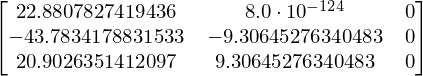

In [9]:
grad.subs([(r_1x,ta[0]),(r_1y,ta[1]),(r_1z,ta[2]),
           (r_2x,tb[0]),(r_2y,tb[1]),(r_2z,tb[2]),
           (r_3x,tc[0]),(r_3y,tc[1]),(r_3z,tc[2]) ]).evalf()


The gradient component at (1,2) is not exactly zero because the simplifier may not have recognized that some terms could be cancelled.

## Value of the inverse radius and its gradient

In [10]:
ir=1/R
ir_grad=derive_by_array(ir,X).tomatrix()

In [11]:
ir.subs([(r_1x,ta[0]),(r_1y,ta[1]),(r_1z,ta[2]),
         (r_2x,tb[0]),(r_2y,tb[1]),(r_2z,tb[2]),
         (r_3x,tc[0]),(r_3y,tc[1]),(r_3z,tc[2]) ]).evalf()

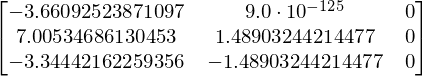

In [12]:
ir_grad.subs([(r_1x,ta[0]),(r_1y,ta[1]),(r_1z,ta[2]),
              (r_2x,tb[0]),(r_2y,tb[1]),(r_2z,tb[2]),
              (r_3x,tc[0]),(r_3y,tc[1]),(r_3z,tc[2]) ]).evalf()

## Limits to infinite curvature (collinearity)
### Radius

In [13]:
u=Symbol("u")
ua=Matrix([-1,0,0])
ub=Matrix([1,0,0])
uc=Matrix([0,u,0])

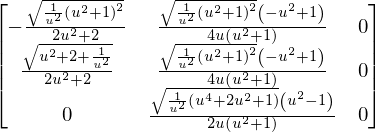

In [14]:
gl=grad.subs([(r_1x,ua[0]),(r_1y,ua[1]),(r_1z,ua[2]),
              (r_2x,ub[0]),(r_2y,ub[1]),(r_2z,ub[2]),
              (r_3x,uc[0]),(r_3y,uc[1]),(r_3z,uc[2]) ])
gl.simplify()
gl

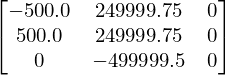

In [15]:
gl.subs(u,.001)

### Inverse radius

The following shows that although the inverse radius for three collinear points is zero, its gradient is undefined. (It is finite, but depends on the direction of approach).

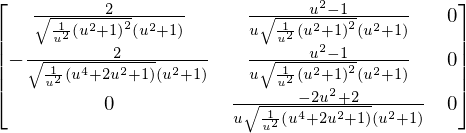

In [16]:
igl=ir_grad.subs([(r_1x,ua[0]),(r_1y,ua[1]),(r_1z,ua[2]),
                  (r_2x,ub[0]),(r_2y,ub[1]),(r_2z,ub[2]),
                  (r_3x,uc[0]),(r_3y,uc[1]),(r_3z,uc[2])  ])
igl.simplify()
igl

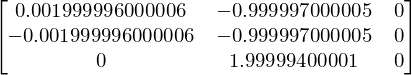

In [17]:
igl.subs(u,.001)

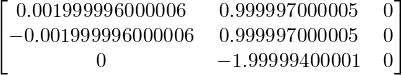

In [18]:
igl.subs(u,-.001)

In [19]:
limit(igl[2,1],u,0,"-")

## Permutation invariance

In [20]:
tb=tr*Matrix([1,0,0])
tc=tr*Matrix([cos(tt),sin(tt),0])
ta=tr*Matrix([cos(2*tt),sin(2*tt),0])

R.subs([ (r_1x,ta[0]),(r_1y,ta[1]),(r_1z,ta[2]),
         (r_2x,tb[0]),(r_2y,tb[1]),(r_2z,tb[2]),
         (r_3x,tc[0]),(r_3y,tc[1]),(r_3z,tc[2]) ]).evalf()

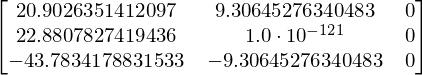

In [21]:
grad.subs([(r_1x,ta[0]),(r_1y,ta[1]),(r_1z,ta[2]),
           (r_2x,tb[0]),(r_2y,tb[1]),(r_2z,tb[2]),
           (r_3x,tc[0]),(r_3y,tc[1]),(r_3z,tc[2])]).evalf()

# Sample printout

The analytical expressions are lengthy. Here's for examples $\partial R/\partial r_{1y}$. (The index in square brackets is the Cartesian component, 0 to 2).

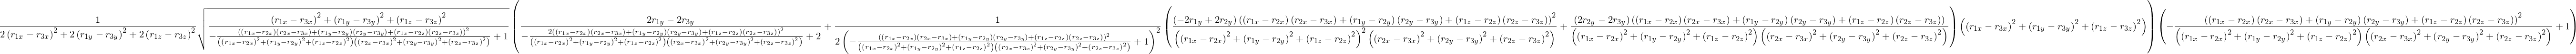

In [22]:
mgrad_1[1]

We can replace the repeated  $|r_{ij}|^2$ subexpressions  to obtain a more readable form.

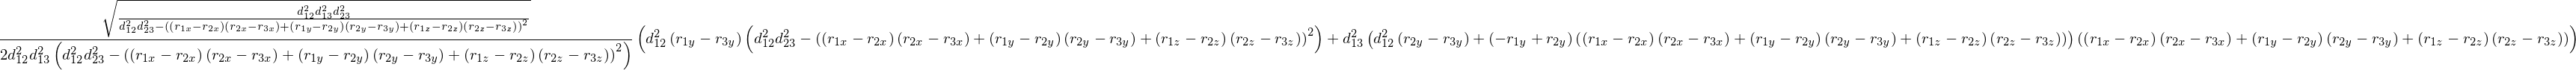

In [23]:
repl = [ (r_12.dot(r_12), Symbol("d_12")**2),
         (r_23.dot(r_23), Symbol("d_23")**2),
         (r_13.dot(r_13), Symbol("d_13")**2)]

mgrad_1[1].subs(repl).simplify()

# Gradients with respect to distances

Depending on the problem at hand and number of involved atoms, it may be more natural to differentiate with respect to *distances*, and then apply the chain rule in the calling code.  In the specific case of the radius of cuvature, there are 3 coordinates as well as 3 coordinate differences: the number of components of the gradients is the same in both cases, but derivatives w.r.t. distances are more compact, so there is an advantage. 

This is the same code as before, after replacing distances with unevaluated symbols. **Warning:** this cell overwrites the previous symbols!

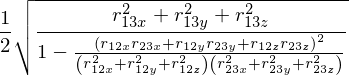

In [24]:
r_12=Matrix([Symbol("r_12x"),Symbol("r_12y"),Symbol("r_12z")])
r_13=Matrix([Symbol("r_13x"),Symbol("r_13y"),Symbol("r_13z")])
r_23=Matrix([Symbol("r_23x"),Symbol("r_23y"),Symbol("r_23z")])

side2 = r_13.dot(r_13)
cos2a = r_12.dot(r_23)**2 / (r_12.dot(r_12) * r_23.dot(r_23))
sin2a = 1-cos2a

R2 = side2/sin2a/4

R=sqrt(R2)
R

Inspect e.g. $\partial R / \partial r_{12x}$ :

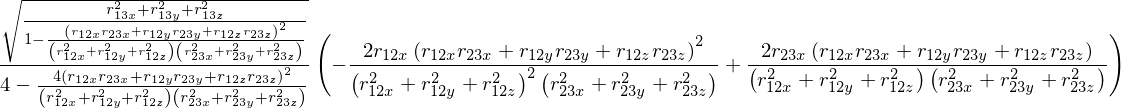

In [25]:
derive_by_array(R,r_12)[0]

Code generation is also straightforward. Here we do with it with all components at once.

The caller should then apply the chain rule to obtain the atomwise generalized force
components to pass to PLUMED, e.g. 

$${\partial R \over \partial r_{1x}} = 
{\partial R \over \partial r_{12x}}{\partial r_{12x} \over \partial r_{1x} } + 
{\partial R \over \partial r_{13x}}{\partial r_{13x} \over \partial r_{1x} } $$

and so on.   LHS is the gradient to be passed to the engine; 
  RHS has terms computed above times terms which are $\pm 1$. 

In [26]:
r_all=Matrix([r_12,r_13,r_23])

codegen([ ("curvature_radius_dist",R),
          ("curvature_radius_grad_dist",   
                Eq(MatrixSymbol("g",9,1),
                   derive_by_array(R,r_all) ))],
             to_files=True,
             prefix="curvature_codegen_dist",
             project="plumed_curvature",
             language="C")


# Version check

This notebook was current on SymPy version...

In [4]:
import sympy
sympy.__version__

'1.0'

In [7]:
import platform
platform.python_version()

'3.6.4'

# Interactive console

In [14]:
# Run the following command for an interactive console:
# %qtconsole